## Coding sprint (15/12)
## Task:
Predict 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)' from other World development indicators
https://datacatalog.worldbank.org/home

### Group 1
https://pypi.org/project/wbgapi/
1. Access world bank data via python API, wbgapi
2. Get the alcohol indicator, and search other indicators (year 2019)
3. Your final product is pandas DataFrame containing 10 relevant indicators of your choice

### Group 2
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
1. Your input is the DF from the above
2. Solve the problem with missing values (what are you going to do? substitute, invent a value, ignore a country?)
3. Find 5 best candidate predictors of the alcohol comsuption out of the 10 in the table

### Group 3
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
1. Your input is Dataframe with 5 predictors (features) and target alcohol column.
2. Split the data into train and test.
3. prepare a linear regression model (scikit learn LinearRegression()) to fit the data
5. Find evaluation metrics of the model.
6. Predict the test data. How is the performance between train and test?

In [1]:
import wbgapi as wb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn import linear_model
from pandas_datapackage_reader import read_datapackage
from tqdm import tqdm
# pip install pandas-datapackage-reader

## Intro to wbgapi

In [2]:
# help for API methods
# help(wb.series)

In [3]:
# fultext search of datasets
# wb.search('alcohol')

In [4]:
# search available series
wb.series.info(q='alcohol')

id,value
SH.ALC.PCAP.FE.LI,"Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age)"
SH.ALC.PCAP.LI,"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)"
SH.ALC.PCAP.MA.LI,"Total alcohol consumption per capita, male (liters of pure alcohol, projected estimates, male 15+ years of age)"
,3 elements


## Help functions for the DataFrame data

In [2]:
def merge2dfs(df1, df2, on, verbose=1):
    out = df1.merge(df2, on=on)
    if verbose:
        print('Discarded from df2:', set(df1[on]) - (set(out[on])))
    return out

## filter countries from other economic units
def filter_years(data_ID, iso_df, number_years=5, verbose=1):
    """Gets DF from WB by data_ID for the last
    number_years. goes column by column and:
        1. filters valid country ISO codes.
        2. count valid values and tracks which year has
            the most valid values

    Args:
        data_ID (str): WB series ID
        iso_df (pd.DataFrame): DF of valid country isocodes
        number_years (int, optional): number of year columns in the WB dataframe.
            Defaults to 5.
    Returns:
        out (pd.DataFrame): first is economy column (country 3 letter isocode),
            second is year data, containing max valid values.
        
    """
    # query data from WB
    df = wb.data.DataFrame(data_ID, labels=True, mrv=number_years).reset_index()

    # keep only data for independet countries only
    df = df[df['economy'].isin(iso_df['economy'])].reset_index()

    # list of nans per column
    lista = list(df[df.columns[-number_years:]].select_dtypes(include='number').isna().sum())
    # lista = list(df.isna().sum())
    # taking care of datasets with less incomming columns than number_years
    # short version of this code is just number_years = len(lista), because it is either the same
    # meaning no change, or different and number_years is getting changes.
    if len(lista) != number_years:
        # print(f'received only {len(lista)} columns, setting number_years accordingly')
        number_years = len(lista)

    # minimal value for last `number_years columns`
    # TODO: invert list in order to find minimum which is in the newest data, if two minima are the same
    min_nans = int(min(lista[-number_years:]))
    # ::-1 just a bad trick to get index of the last minima (want the most recent datasets, if two minima are the same)
    idx = lista[-number_years:][::-1].index(min_nans)

    # print output controlled by verbose function argument, you can see it quite often
    if verbose:
        print(data_ID, '-- best data collections year:', df.columns[-1-idx], '-- # nans:', min_nans)

    # get the best column
    s = df.columns[-1 - idx]
    # create a resulting DF
    out = df[['economy', s]]

    # rename the year column to data_ID:year
    out = out.rename(columns={s: data_ID + '.' + s[-4:]})
    return  out, min_nans

## setting up

In [3]:
# Get isocodes and continent information for every country
country_codes = read_datapackage("https://github.com/datasets/country-codes")
iso_df = country_codes[country_codes['is_independent']=='Yes'][['ISO3166-1-Alpha-3', 'Continent', 'Sub-region Name', 'CLDR display name']]
iso_df.rename(columns={'ISO3166-1-Alpha-3': 'economy'}, inplace=True)

# if you have geopandas, you can get geographical information too
# geo_countries = read_datapackage("https://github.com/datasets/geo-countries")

## Get the full DF

In [4]:
# get only alcohol dataset
df_target, _ = filter_years('SH.ALC.PCAP.LI', iso_df, 3)

SH.ALC.PCAP.LI -- best data collections year: YR2019 -- # nans: 6


In [8]:
# df_target.head()

In [58]:
# print all 1430 dataset IDs
# for i in wb.series.list():
#     print(i)

all_data_lst = list(wb.series.list())
len(all_data_lst)

1486

In [98]:
try:
    del df_full
except:
    pass

sel_lst = []
count_bad_datasets = 0
# goes in steps of 10 through all available datasets (takes  7+ mins)
# 1 iteration on my machine takes 3s, for 1400 dataset would take 75mins

# alternatively you can comment out the forloop and load my result of this
# particular run ([::10] step) and comment out the saving part below
df_full = pd.read_csv('DP_good_datasets_all_th03.csv', index_col=0)
# for i, el in tqdm(enumerate(all_data_lst)):  # tqdm used a lot in AI model training
#     try:
#         # some datasets throw errors, that is why I use try except
#         df, nNans = filter_years(el['id'], iso_df, number_years=5, verbose=0)
#         # print(el['id'], df.isna().sum(), df.corrwith(df_target['SH.ALC.PCAP.LI.2010'], axis=0, numeric_only=True))

#         # correlation value of dataset with alcohol consumption
#         corr = abs(df.corrwith(df_target['SH.ALC.PCAP.LI.2019'], axis=0, numeric_only=True).iloc[0])
#     except Exception as e:
#         print('Incomming dataset problem:', e)
#         count_bad_datasets += 1
#         continue
#     if nNans < 5 and corr > 0.3: # tolerate only small amount of nans
#         try:
#             df_full = merge2dfs(df_full, df, on='economy', verbose=0)
#         except:
#             df_full = merge2dfs(iso_df, df, on='economy', verbose=0)   
#         print(f'Taking ({el["id"]}), valid values: {int(df.describe().iat[0, -1])}, corr: {corr}')
#         sel_lst.append(el)

In [68]:
## show correlations
# df_full.head()

In [69]:
# save the df_full
# df_full.to_csv('DP_good_datasets_all_th03.csv')

In [70]:
# remove countries with any nans 
df = df_full[-df_full.isnull().any(axis=1)]
df_target = df_target[-df_target.isnull().any(axis=1)]
# df.head()

In [71]:
# merge target onto the df
df = df.merge(df_target, on='economy')
# df.head()

### TASK: Visualize the correlation matrix

In [72]:
corr = df.corr(numeric_only=True)
# corr

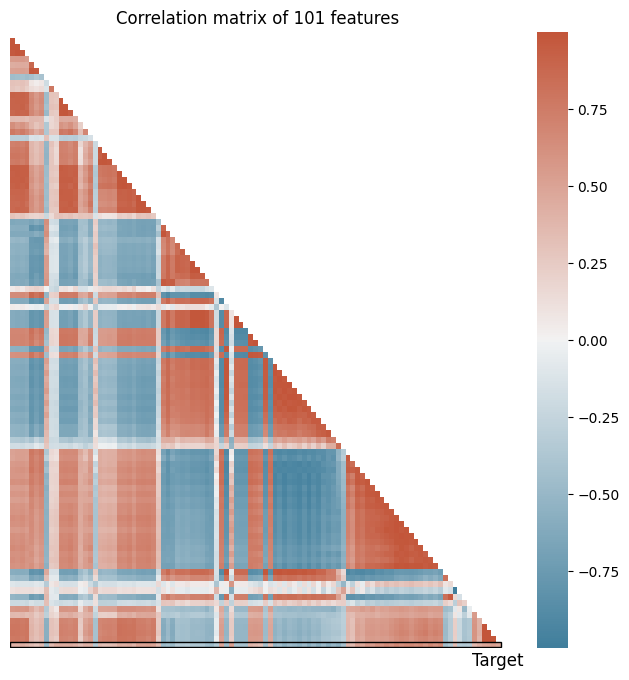

In [73]:
# mask for the upper triangle
import matplotlib.patches as p
mask = np.triu(np.ones_like(corr, dtype=bool))

# matplotlib figure settings
f, ax = plt.subplots(figsize=(8, 8))

# colormap settings
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# creates the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, yticklabels=False,  xticklabels=False)
plt.title('Correlation matrix of 101 features')
rect = p.Rectangle((0, 101), 101, 0.9, color='k', fill=False, in_layout=False)
ax.add_patch(rect)
ax.text(95, 105, 'Target', fontsize='large')
plt.savefig('figs\\corr_heatmap.png', dpi=180)
plt.show()

In [92]:
df18 = df[['economy', 'Continent', 'Sub-region Name',
         'CLDR display name', 'CC.EST.2022', 'EG.CFT.ACCS.ZS.2021', 'EN.ATM.PM25.MC.M3.2019',
         'ER.PTD.TOTL.ZS.2022', 'GE.PER.RNK.LOWER.2022', 'IT.NET.SECR.P6.2020',
          'NY.GDP.TOTL.RT.ZS.2018', 'RQ.PER.RNK.2022', 'SG.GEN.PARL.ZS.2019',
          'SH.PRG.ANEM.2019', 'SH.STA.DIAB.ZS.2021', 'SP.DYN.CDRT.IN.2018',
          'SP.POP.2024.MA.5Y.2022', 'SP.POP.80UP.FE.5Y.2022', 'TM.VAL.MRCH.HI.ZS.2020',
          'TX.VAL.MRCH.HI.ZS.2020', 'VA.EST.2022', 'SH.ALC.PCAP.LI.2019',
        ]]

In [76]:
# example feature vs alcohol cons plot
# sns.scatterplot(data=df, x="CC.EST.2022", y='SH.ALC.PCAP.LI.2019')
# plt.show()

## Regression on the whole set of features (use df), or subset (use df22)
* illustrative comparison for changing number of features for the linear regression

In [93]:
# use one, comment out the other
DF = df.copy()  # all 101 features
# DF = df18.copy()  # subset of 18 features

In [94]:
def plotRegResult(df_test, y_train, y_train_pred, r2_test=None, r2_train=None):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    sns.scatterplot(ax=ax[0], x=df_test['SH.ALC.PCAP.LI.2019'], y=df_test['y_pred'], hue=df_test['Continent'], )#hue='Sub-region Name')
    # fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    ax[0].plot(range(15), range(15), 'k')
    ax[0].title.set_text(f'Test: r2={r2_test:0.2f}')

    sns.scatterplot(ax=ax[1], x=y_train, y=y_train_pred )#hue='Sub-region Name')
    ax[1].title.set_text(f'Train: r2={r2_train:0.2f}')
    # fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.plot(range(15), range(15), 'k')
    plt.show()

In [95]:
# split data into training and testing set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(DF[DF.columns[4:-1]], DF[DF.columns[-1]],
                                                                            test_size=0.2, random_state=42)

# scaling data
# scaler = sklearn.preprocessing.StandardScaler()
# X_train = scaler.fit_transform(X_train)

# fit the model
reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [96]:
# predict from model, input is only X_test, y_pred should be close to y_test, wchich is so-called ground truth
y_pred = reg.predict(X_test)
# making it into a series with correct index
sy_pred = pd.Series(y_pred, index=X_test.index, name='y_pred')

# merge
# df_test = df.merge(pd.Series(y_test, name='y_test'), left_index=True, right_index=True) # y_test is also SH.ALC.PCAP.LI.2019	
df_test = df.merge(sy_pred, left_index=True, right_index=True)
df_test = df_test.merge(X_test)

r2_test = sklearn.metrics.r2_score(y_true=df_test['SH.ALC.PCAP.LI.2019'], y_pred=df_test['y_pred'], sample_weight=None)

# Train predictions
# predict from model, input is only X_test, y_pred should be close to y_test, wchich is so-called ground truth
y_train_pred = reg.predict(X_train)
# making it into a series with correct index
sy_train_pred = pd.Series(y_train_pred, index=X_train.index, name='y_train_pred')
r2_train = sklearn.metrics.r2_score(y_true=y_train, y_pred=y_train_pred, sample_weight=None)

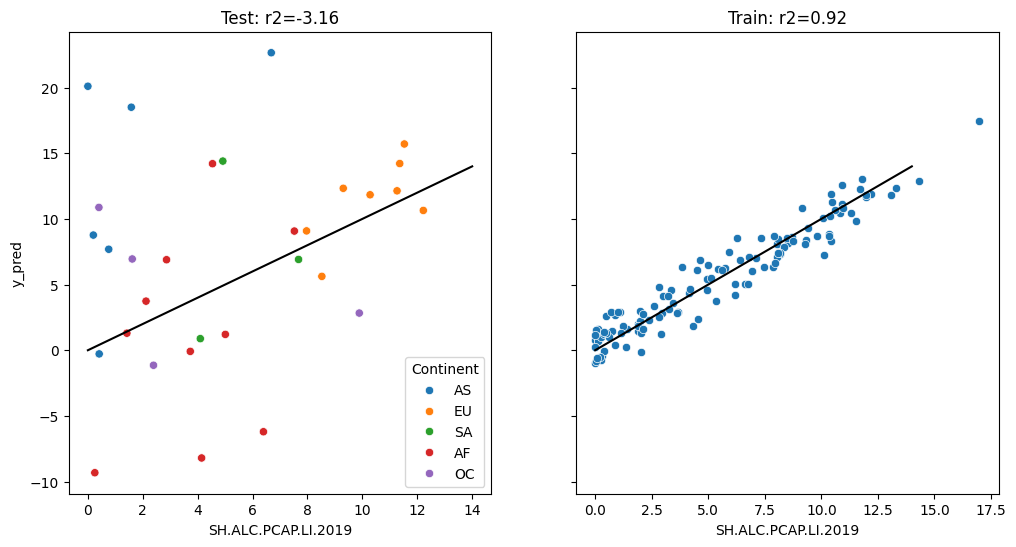

In [97]:
# This is where you can see the comparison between the two models.
plotRegResult(df_test, y_train, y_train_pred, r2_test, r2_train)

## Ready for 02/02

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif, r_regression

selector = SelectKBest(r_regression, k=2)
X_new = selector.fit_transform(X_train, y_train)

In [82]:
X_new.shape

(122, 2)

In [142]:
selector.get_feature_names_out()

array(['SP.DYN.CDRT.IN.2018', 'SP.POP.80UP.FE.5Y.2022'], dtype=object)

### Fit regression again

In [ ]:
X_train, X_test = X_train[selector.get_feature_names_out()], X_test[selector.get_feature_names_out()]

In [144]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [145]:
# predict from model, input is only X_test, y_pred should be close to y_test, wchich is so-called ground truth
y_pred = reg.predict(X_test)
# making it into a series with correct index
sy_pred = pd.Series(y_pred, index=X_test.index, name='y_pred')

### TASK: evaluate model metrics (more than one) for both the train and test data

In [146]:
# merge
# df_test = df.merge(pd.Series(y_test, name='y_test'), left_index=True, right_index=True) # y_test is also SH.ALC.PCAP.LI.2010 	
df_test = df.merge(sy_pred, left_index=True, right_index=True)
df_test = df_test.merge(X_test)

In [147]:
# df_test.head()

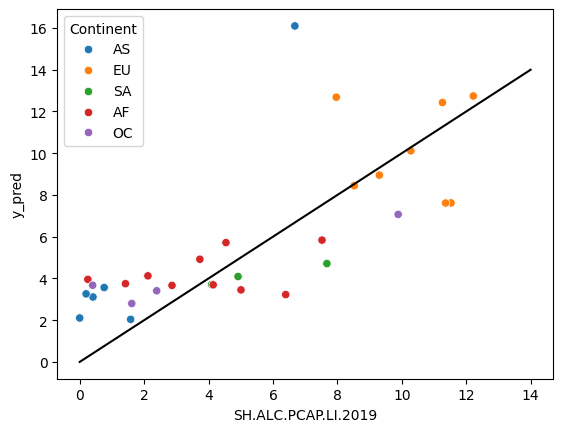

In [148]:
# plot with seaborn
fig = sns.scatterplot(df_test, x='SH.ALC.PCAP.LI.2019', y='y_pred', hue='Continent', )#hue='Sub-region Name')
# fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.plot(range(15), range(15), 'k')
plt.show()

### You see that continent itself might be a good predictor
* TASK: look into how to create a categorical feature out of continent values.

In [150]:
# evaluation of prediction on testing set
r2 = sklearn.metrics.r2_score(y_true=df_test['SH.ALC.PCAP.LI.2019'], y_pred=df_test['y_pred'], sample_weight=None)
r2

0.4837714667796079

In [151]:
# predict from model, input is only X_test, y_pred should be close to y_test, wchich is so-called ground truth
y_train_pred = reg.predict(X_train)
# making it into a series with correct index
sy_train_pred = pd.Series(y_train_pred, index=X_train.index, name='y_train_pred')
# len(y_pred)

In [152]:
# evaluation of prediction on training set
r2 = sklearn.metrics.r2_score(y_true=y_train, y_pred=y_train_pred, sample_weight=None)
r2

0.47669779941261503